In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts.timeseries import TimeSeries, concatenate
from darts.models.forecasting.linear_regression_model import LinearRegressionModel
from darts.metrics.metrics import mae

In [2]:
output_dir = "./OutputData/"

In [3]:
# Load data, first 90 days, 2 time series
df = pd.read_csv(output_dir + "train_data.csv")
df["time"] = pd.to_datetime(df["time"])
df = df[["time", "consumption_MWh", "consumption_lag2"]]
df = df.iloc[0:90*24, :]

In [4]:
df

,time,consumption_MWh,consumption_lag2
0,2018-01-01 02:00:00,24635.32,27412.81
1,2018-01-01 03:00:00,23872.12,26324.39
2,2018-01-01 04:00:00,23194.89,24635.32
3,2018-01-01 05:00:00,23071.96,23872.12
4,2018-01-01 06:00:00,23267.90,23194.89
...,...,...,...
2155,2018-03-31 21:00:00,34303.74,34973.00
2156,2018-03-31 22:00:00,34057.45,35244.02
2157,2018-03-31 23:00:00,32470.93,34303.74
2158,2018-04-01 00:00:00,30326.03,34057.45


In [5]:
# Long convert
df_long = pd.melt(df, 
        id_vars = "time", 
        value_vars = ["consumption_MWh", "consumption_lag2"]
       )

In [6]:
df_long

,time,variable,value
0,2018-01-01 02:00:00,consumption_MWh,24635.32
1,2018-01-01 03:00:00,consumption_MWh,23872.12
2,2018-01-01 04:00:00,consumption_MWh,23194.89
3,2018-01-01 05:00:00,consumption_MWh,23071.96
4,2018-01-01 06:00:00,consumption_MWh,23267.90
...,...,...,...
4315,2018-03-31 21:00:00,consumption_lag2,34973.00
4316,2018-03-31 22:00:00,consumption_lag2,35244.02
4317,2018-03-31 23:00:00,consumption_lag2,34303.74
4318,2018-04-01 00:00:00,consumption_lag2,34057.45


In [7]:
# Create list of timeseries from long data
ts_list = TimeSeries.from_group_dataframe(df_long,
                                         time_col = "time",
                                         group_cols = "variable",
                                         value_cols = "value"
                                         )

In [27]:
# Create model with future covariates
model = LinearRegressionModel(
    lags = 1,
    lags_future_covariates = [0], # Use future covariates at T to predict target at T
    output_chunk_length = 1,
    use_static_covariates = False,
    add_encoders = {
        "cyclic": {"future": ["month", "dayofweek", "hour"]}
    }
)
    

In [28]:
# Get historical forecasts for one series
hist_forecasts_list = model.historical_forecasts(ts_list[0],
                                                start = 30 * 24, # Start by training on first 30 days
                                                forecast_horizon = 24, # Forecast next 24 hours at a time
                                                stride = 24, # Expand training window by 24 at a time
                                                retrain = True, 
                                                last_points_only = False
                                                )

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


In [29]:
print("done")

done


In [30]:
len(hist_forecasts_list)

60

In [31]:
# Concatenate historical forecasts into one TS
hist_forecasts = concatenate(hist_forecasts_list)

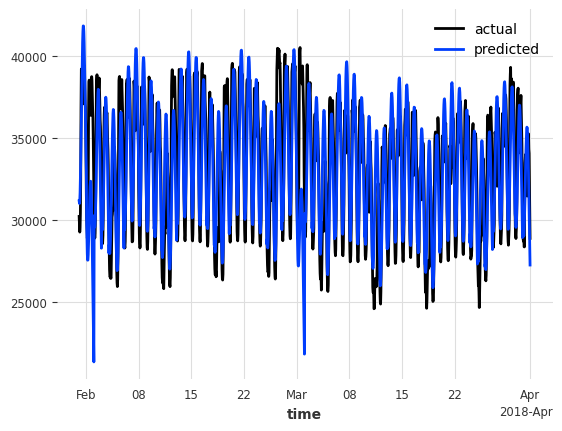

In [35]:
_ = ts_list[0][hist_forecasts.time_index].plot(label = "actual")
_ = hist_forecasts.plot(label = "predicted")

In [36]:
# Calculate a performance metric
mae(
    ts_list[0],
    hist_forecasts,
    intersect = True # Calculate only for matching time indices
)


2124.189059474831

In [54]:
# Get forecasts as dataframe
df_hist = hist_forecasts.pd_dataframe().reset_index()
df_hist["variable"] = hist_forecasts.static_covariates["variable"].value

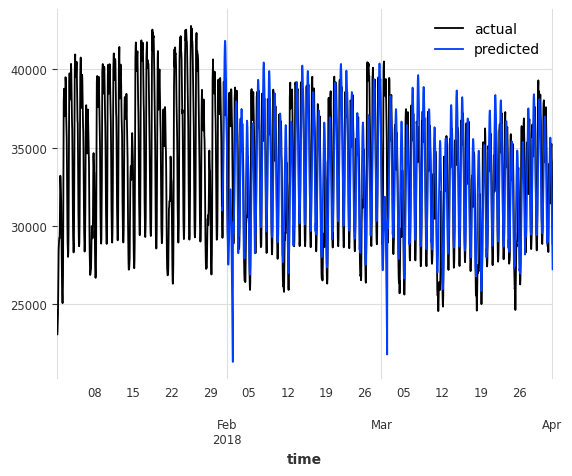

In [59]:
# Plot with original long dataframe
fig, ax = plt.subplots()
_ = df_long.query("variable == 'consumption_MWh'").plot(x = "time",  y = "value", label = "actual", ax = ax)
_ = df_hist.plot(x = "time", y = "value", label = "predicted", ax = ax)